In [11]:
from nltk.corpus import wordnet as wn
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras
import keras.utils
from keras import utils as np_utils
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [12]:
df=pd.read_csv('labels.csv')

In [13]:
df

event_id        Words   POS Index  Tag  Labels      Tag2
0      0        A            DT    0     O    0.0     O       
1      0        shooting     NN    2     O    0.0     O       
2      0        takes        VBZ   11    O    0.0     O       
3      0        place        NN    17    O    0.0     O       
4      0        at           IN    23    O    0.0     O       
5      0         a           DT    26    O    0.0     O       
6      0        pub          NN    28    arg  1.0     O       
7      0         in          IN    31    O    0.0     relation
8      0        Tel          NNP   35    arg  1.0     O       
9      0        Aviv         NNP   39    arg  1.0     O       
10     0        Israel       NNP   44    arg  1.0     O       
11     0        leaving      VBG   51    O    0.0     O       
12     0        two          CD    59    O    0.0     O       
13     0        dead         JJ    63    O    0.0     O       
14     0         and         CC    67    O    0.0     O       
15     0        eight        CD    72    O    0.0     O       
16     0        injured      VBN   78    O    0.0     O       
17     DT       .            .     B-NP  O    0.0     O       
18     0        gunman       NN    91    O    0.0     O       
19     0        managed      VBD   98    O    0.0     O       
20     0        to           TO    106   O    0.0     O       
21     0        escape       VB    109   O    0.0     O       
22     0        possibly     RB    120   O    0.0     O       
23     0        killed       VBN   129   O    0.0     O       
24     0        his          PRP$  136   O    0.0     O       
25     0        accomplice   NN    140   O    0.0     O       
26     0        an           DT    68    O    0.0     O       
27     0        Arab         NNP   154   O    0.0     O       
28     0        taxi         NN    159   O    0.0     O       
29     0        driver       NN    164   O    0.0     O       
...   ..           ...       ..    ...  ..    ...    ..       
51662  1999     rainfall     NN    7     O    0.0     O       
51663  1999      and         CC    15    O    0.0     O       
51664  1999     severe       JJ    20    arg  1.0     O       
51665  1999     flooding     VBG   27    arg  1.0     O       
51666  1999      in          IN    35    O    0.0     relation
51667  1999     southeast    RB    39    arg  1.0     O       
51668  1999     Texas        NNP   49    arg  1.0     O       
51669  1999     has          VBZ   55    O    0.0     O       
51670  1999     killed       VBN   59    O    0.0     O       
51671  1999     at           IN    66    O    0.0     O       
51672  1999     least        JJS   69    O    0.0     O       
51673  1999     two          CD    75    O    0.0     O       
51674  1999     people       NNS   79    O    0.0     O       
51675  1999     with         IN    86    O    0.0     O       
51676  1999     three        CD    91    O    0.0     O       
51677  1999     others       NNS   97    O    0.0     O       
51678  1999     missing      VBG   104   O    0.0     O       
51679  IN       .            .     B-PP  O    0.0     O       
51680  1999     Thursday     NNP   116   O    0.0     O       
51681  1999      a           DT    125   O    0.0     O       
51682  1999     record       NN    127   O    0.0     O       
51683  1999     16.6         CD    134   O    0.0     O       
51684  1999     inches       NNS   139   O    0.0     O       
51685  1999     fortytwo     NN    146   O    0.0     O       
51686  1999     centimeters  NNS   155   O    0.0     O       
51687  1999     of           IN    167   O    0.0     O       
51688  1999     fell         VBD   175   O    0.0     O       
51689  1999     Brenham      NNP   183   O    0.0     O       
51690  1999     west         NN    191   O    0.0     O       
51691  1999     Houston      NNP   199   O    0.0     O       

[51692 rows x 7 columns]

# 1. Small checker 

In [14]:
# for i in range(0,25662):
#     if df.loc[i,'Words']=='Northrop':
#         print("\n")
#         print(i)
#         print(df.loc[i,'event_id'])
        
#         print(df.loc[i,'Words'])
#         print(df.loc[i+1,'Words'])
#         print(df.loc[i+2,'Words'])
#         print(df.loc[i+3,'Words'])
    

In [15]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t,m) for w, p, t,m in zip(s["Words"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist(),
                                                           s["Tag2"].values.tolist())]
        self.grouped = self.data.groupby("event_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None
getter = SentenceGetter(df)


In [16]:
words = set(df["Words"].values.tolist())
# words.append("ENDPAD")
n_words = len(words); 
print(n_words)
tags = set(df["Tag"].values.tolist())
n_tags = len(tags); 
tags2 = set(df["Tag2"].values.tolist())
n_tags2 = len(tags2); 
print(n_tags2)
sent = getter.get_next()
print(sent)



10767
2
[('A', 'DT', 'O', 'O'), ('new', 'JJ', 'O', 'O'), ('28foot', 'NN', 'O', 'O'), ('tall', 'JJ', 'O', 'O'), ('statue', 'NN', 'O', 'O'), ('of', 'IN', 'O', 'O'), ('Jesus', 'NNP', 'arg', 'O'), ('dubbed', 'VBN', 'O', 'O'), ('de', 'FW', 'arg', 'O'), ('Greatest', 'JJS', 'arg', 'O'), ('is', 'VBZ', 'O', 'O'), ('unveiled', 'VBD', 'O', 'relation'), (' on ', 'IN', 'O', 'relation'), ('New', 'NNP', 'arg', 'O'), ('Years', 'NNS', 'arg', 'O'), ('Day', 'NNP', 'O', 'O'), ('outside', 'IN', 'O', 'O'), ('St.', 'NNP', 'O', 'O'), ('Aloysius', 'NNP', 'O', 'O'), ('Catholic', 'NNP', 'O', 'O'), ('Church', 'NNP', 'O', 'O'), (' in ', 'IN', 'O', 'O'), ('Abajah', 'NNP', 'O', 'O'), ('village', 'NN', 'O', 'O'), ('Nigerias', 'NNP', 'O', 'O'), ('Imo', 'NNP', 'O', 'O'), ('state', 'NN', 'O', 'O'), ('which', 'WDT', 'O', 'O'), ('described', 'VBN', 'O', 'O'), (' as ', 'IN', 'O', 'O'), ('tallest', 'JJS', 'O', 'O'), ('Africa', 'NNP', 'O', 'O')]


In [17]:
sentences = getter.sentences

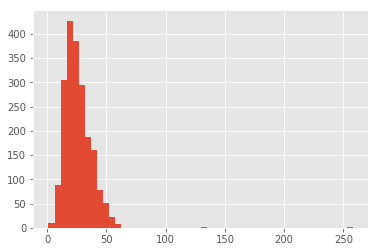

In [18]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [19]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
word2idx

NameError: name 'word2idx' is not defined

In [259]:
max_len = 250
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
word2idx = {w: i for i, w in enumerate(words)} #vocab for words
# print(tag2idx)
tag2idx = {t: i for i, t in enumerate(tags)} #vocab for tags arguments
tag22idx = {t: i for i, t in enumerate(tags2)} #vocab for tags relation
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)
#......................output 1 label arguments........................
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]
#.....................output 2 label Relations..........................
y1 = [[tag22idx[w[3]] for w in s] for s in sentences]
y1 = pad_sequences(maxlen=max_len, sequences=y1, padding="post", value=tag22idx["O"])
y1 = [to_categorical(i, num_classes=n_tags2) for i in y1]


X_tr, X_te, y_tr, y_te,y1_tr, y1_te = train_test_split(X,y, y1, test_size=0.1)

In [260]:
y

[array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1

In [261]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=250, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="sigmoid"))(model)  # softmax output layer
out1 = TimeDistributed(Dense(n_tags2, activation="sigmoid"))(model) 
model = Model(input, [out,out1])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy",f1_m,precision_m, recall_m])

In [262]:
history = model.fit(X_tr, [np.array(y_tr),np.array(y1_tr)],validation_data=(X_te, [y_te,y1_te]), batch_size=32, epochs=50, validation_split=0.2, verbose=1)


Train on 1816 samples, validate on 202 samples
Epoch 1/50
1816/1816 [==============================] - 118s 65ms/step - loss: 0.2389 - time_distributed_27_loss: 0.1322 - time_distributed_28_loss: 0.1068 - time_distributed_27_acc: 0.9793 - time_distributed_27_f1_m: 0.9793 - time_distributed_27_precision_m: 0.9792 - time_distributed_27_recall_m: 0.9795 - time_distributed_28_acc: 0.9844 - time_distributed_28_f1_m: 0.9871 - time_distributed_28_precision_m: 0.9846 - time_distributed_28_recall_m: 0.9922 - val_loss: 0.0734 - val_time_distributed_27_loss: 0.0491 - val_time_distributed_28_loss: 0.0243 - val_time_distributed_27_acc: 0.9795 - val_time_distributed_27_f1_m: 0.9795 - val_time_distributed_27_precision_m: 0.9795 - val_time_distributed_27_recall_m: 0.9795 - val_time_distributed_28_acc: 0.9934 - val_time_distributed_28_f1_m: 0.9934 - val_time_distributed_28_precision_m: 0.9934 - val_time_distributed_28_recall_m: 0.9934
Epoch 2/50
1816/1816 [==============================] - 74s 41ms/ste

1816/1816 [==============================] - 90s 50ms/step - loss: 0.0083 - time_distributed_27_loss: 0.0040 - time_distributed_28_loss: 0.0043 - time_distributed_27_acc: 0.9987 - time_distributed_27_f1_m: 0.9987 - time_distributed_27_precision_m: 0.9987 - time_distributed_27_recall_m: 0.9988 - time_distributed_28_acc: 0.9986 - time_distributed_28_f1_m: 0.9986 - time_distributed_28_precision_m: 0.9985 - time_distributed_28_recall_m: 0.9986 - val_loss: 0.1113 - val_time_distributed_27_loss: 0.0845 - val_time_distributed_28_loss: 0.0268 - val_time_distributed_27_acc: 0.9810 - val_time_distributed_27_f1_m: 0.9810 - val_time_distributed_27_precision_m: 0.9810 - val_time_distributed_27_recall_m: 0.9811 - val_time_distributed_28_acc: 0.9935 - val_time_distributed_28_f1_m: 0.9935 - val_time_distributed_28_precision_m: 0.9934 - val_time_distributed_28_recall_m: 0.9936
Epoch 20/50
1816/1816 [==============================] - 88s 48ms/step - loss: 0.0080 - time_distributed_27_loss: 0.0039 - time

1816/1816 [==============================] - 110s 61ms/step - loss: 0.0024 - time_distributed_27_loss: 0.0011 - time_distributed_28_loss: 0.0013 - time_distributed_27_acc: 0.9997 - time_distributed_27_f1_m: 0.9997 - time_distributed_27_precision_m: 0.9997 - time_distributed_27_recall_m: 0.9997 - time_distributed_28_acc: 0.9996 - time_distributed_28_f1_m: 0.9996 - time_distributed_28_precision_m: 0.9996 - time_distributed_28_recall_m: 0.9996 - val_loss: 0.1465 - val_time_distributed_27_loss: 0.1107 - val_time_distributed_28_loss: 0.0358 - val_time_distributed_27_acc: 0.9810 - val_time_distributed_27_f1_m: 0.9810 - val_time_distributed_27_precision_m: 0.9811 - val_time_distributed_27_recall_m: 0.9810 - val_time_distributed_28_acc: 0.9934 - val_time_distributed_28_f1_m: 0.9934 - val_time_distributed_28_precision_m: 0.9934 - val_time_distributed_28_recall_m: 0.9935
Epoch 38/50
1816/1816 [==============================] - 106s 58ms/step - loss: 0.0023 - time_distributed_27_loss: 0.0010 - ti

In [232]:
train_acc = model.evaluate(X_tr, [y_tr,y1_tr], verbose=0)
test_acc = model.evaluate(X_te,  [y_te,y1_te], verbose=0)
print(train_acc, test_acc)

[0.0008572555105571147, 0.0003322478795207684, 0.0005250076281516054, 0.9999427343780248, 0.9999427186234933, 0.999942735428327, 0.999942735428327, 0.999876656721342, 0.9998766265251563, 0.9998810595877895, 0.9998722538548944] [0.16567942027998442, 0.12602038814289734, 0.039659031915782704, 0.9801683231155471, 0.9801668406713127, 0.9802348035396916, 0.9800989999629484, 0.993455447182797, 0.9934552010923329, 0.9934847927329564, 0.9934257440047689]


In [264]:
# from keras.utils import plot_model
# plot_model(model, to_file='model_plot4b.png', show_shapes=True, show_layer_names=True)

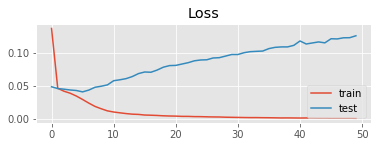

In [251]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['time_distributed_23_loss'], label='train')
pyplot.plot(history.history['val_time_distributed_23_loss'], label='test')
pyplot.legend()

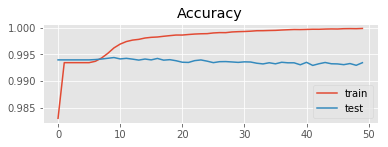

In [236]:
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['time_distributed_24_acc'], label='train')
pyplot.plot(history.history['val_time_distributed_24_acc'], label='test')
pyplot.legend()
pyplot.show()

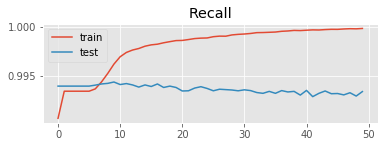

In [238]:
pyplot.subplot(212)
pyplot.title('Recall')
pyplot.plot(history.history['time_distributed_24_recall_m'], label='train')
pyplot.plot(history.history['val_time_distributed_24_recall_m'], label='test')
pyplot.legend()
pyplot.show()

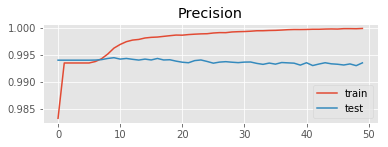

In [240]:
pyplot.subplot(212)
pyplot.title('Precision')
pyplot.plot(history.history['time_distributed_24_precision_m'], label='train')
pyplot.plot(history.history['val_time_distributed_24_precision_m'], label='test')
pyplot.legend()
pyplot.show()

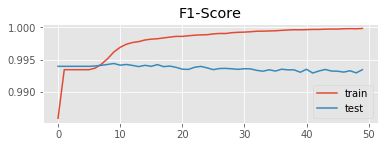

In [242]:
pyplot.subplot(212)
pyplot.title('F1-Score')
pyplot.plot(history.history['time_distributed_24_f1_m'], label='train')
pyplot.plot(history.history['val_time_distributed_24_f1_m'], label='test')
pyplot.legend()
pyplot.show()

In [263]:
# scores = model.evaluate(vectorizer.transform(X_te), y_te, verbose=1)
# print("Accuracy:", scores[1])  # Accuracy: 0.875

NameError: name 'vectorizer' is not defined

In [243]:
hist = pd.DataFrame(history.history)
# print(hist)

In [244]:
hist.loc[49]

val_loss                               0.165679
val_time_distributed_23_loss           0.126020
val_time_distributed_24_loss           0.039659
val_time_distributed_23_acc            0.980168
val_time_distributed_23_f1_m           0.980167
val_time_distributed_23_precision_m    0.980235
val_time_distributed_23_recall_m       0.980099
val_time_distributed_24_acc            0.993455
val_time_distributed_24_f1_m           0.993455
val_time_distributed_24_precision_m    0.993485
val_time_distributed_24_recall_m       0.993426
loss                                   0.001250
time_distributed_23_loss               0.000547
time_distributed_24_loss               0.000703
time_distributed_23_acc                0.999898
time_distributed_23_f1_m               0.999898
time_distributed_23_precision_m        0.999899
time_distributed_23_recall_m           0.999896
time_distributed_24_acc                0.999834
time_distributed_24_f1_m               0.999834
time_distributed_24_precision_m        0

AttributeError: 'Model' object has no attribute 'predict_classes'

In [75]:
# plt.figure(figsize=(12,12))
# plt.plot(hist["acc"])
# plt.plot(hist["val_acc"])
# plt.show()

In [76]:
X_te

array([[ 1448,  8293, 10075, ..., 10766, 10766, 10766],
       [ 8884,  3726,  8118, ..., 10766, 10766, 10766],
       [   97,  9396,  4946, ..., 10766, 10766, 10766],
       ...,
       [ 3291,  7271,  1014, ..., 10766, 10766, 10766],
       [ 7138,  6472,  7328, ..., 10766, 10766, 10766],
       [ 5881,  9818, 10366, ..., 10766, 10766, 10766]])

In [77]:
pred

0

In [78]:
i = 100
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print('.....................................................................................')
print(p[0][0])
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0][0]):
    print("{:15}: {}".format(list(words)[w], list(tags)[pred]))
print('.....................................................................................')    
print(p[1][0])
for w, pred1 in zip(X_te[i], p[1][0]):
    print("{:15}: {}".format(list(words)[w], list(tags2)[pred1]))

.....................................................................................
[0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Word            (True ): Pred
Japans         : O
Sakurajima     : O
volcano        : O
erupts         : O
prompting      : O
Meteorological : arg
Agency         : arg
to             : O
issue          : arg
 a             : O
not            : O
approach       : O
it             : O
located        : O
 in            : O
southern       : O
Kagoshima      : O
Prefecture     : O
situated       : O
50       

In [117]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


In [118]:
test_pred = model.predict(X_te, verbose=1)


1009/1009 [==============================] - 4s 4ms/step


In [121]:
idx2tag = {i: w for w, i in tag2idx.items()}



In [122]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    


In [127]:
pred_labels = pred2label(test_pred[1])

In [128]:

test_labels = pred2label(y_te)

In [134]:
# y_val_pred=model.predict_classes(y_te)
 

In [129]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))


F1-score: 4.3%


In [135]:
confusion_matrix(test_labels, pred_labels)

NameError: name 'confusion_matrix' is not defined

In [130]:
print(classification_report(test_labels, pred_labels))


           precision    recall  f1-score   support

      arg       0.04      0.05      0.04      2094

micro avg       0.04      0.05      0.04      2094
macro avg       0.04      0.05      0.04      2094

